In [199]:
import geojson
import geopandas
from importlib import reload
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib

import db
import realtime

%matplotlib inline

## Kontejnery

In [3]:
cont_filename = "data/ZPK_O_Kont_TOitem_b.json"

data = geopandas.read_file(cont_filename)
data[:2]

,OBJECTID,STATIONID,TRASHTYPENAME,CLEANINGFREQUENCYCODE,CONTAINERTYPE,geometry
0,1,1677,Nápojové kartóny,11,240 normální HV,POINT (-735085.4220238626 -1043146.044408377)
1,2,1677,Barevné sklo,41,"1500 M 1,5 SV",POINT (-735085.4220238626 -1043146.044408377)


In [15]:
data.to_crs(epsg=4326, inplace=True)
data[:2]

,OBJECTID,STATIONID,TRASHTYPENAME,CLEANINGFREQUENCYCODE,CONTAINERTYPE,geometry
0,1,1677,Nápojové kartóny,11,240 normální HV,POINT (14.52853198637917 50.09577084364367)
1,2,1677,Barevné sklo,41,"1500 M 1,5 SV",POINT (14.52853198637917 50.09577084364367)


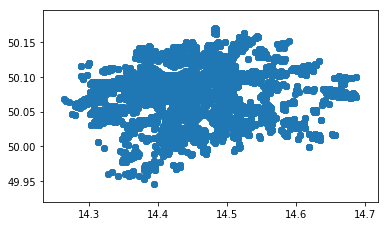

In [16]:
data.plot()

In [84]:
def import_trash(cnt):
    data = geopandas.read_file(cont_filename)
    data.to_crs(epsg=4326, inplace=True)
    for row in data.sample(n=cnt).itertuples():
        point = row.geometry
        issue = db.Issue.create(title="Stanoviště tříděného odpadu",
                                description=row.TRASHTYPENAME,
                                author="MHMP",
                                issue_type=db.IssueType.COMPLAINT,
                                geo_x=point.x, geo_y=point.y)
        db.Response.create(issue=issue.id, text="Kontejner je plný", can_have_message=True)
        db.Response.create(issue=issue.id, text="Okolí kontejneru je znečištěné", can_have_message=True)
        db.Response.create(issue=issue.id, text="Jiný problém", can_have_message=True)

## Lampy - sensory

In [202]:
lamps_filename = "data/lampysensory.csv"

data = pd.read_csv(lamps_filename)
data[:2]

,starttimestamp,sid,geocoordinates_latitude,geocoordinates_longitude,o3,pm2p5,no2,so2,pm10
0,2019-01-01T00:08:11.000Z,6aivodbkkk3xlwbjlkerclrnk4gtfy3x,50.092196,14.449379,3.7,NaN,22.1,14.0,NaN
1,2019-01-01T00:08:11.000Z,6czebgzn24hwd3vpklvuphomcfcwpqgx,50.091231,14.449178,6.3,0.6,10.0,28.8,10.2


In [196]:
def import_lamps():
    data = pd.read_csv(lamps_filename)
    for row in data[["geocoordinates_latitude", "geocoordinates_longitude"]].drop_duplicates(keep="last").itertuples():
        issue = db.Issue.create(title="Lampa se senzory",
                                description="",
                                author="MHMP",
    # todo: realtime_data_url: https://golemio.docs.apiary.io/#introduction/mestsky-mobiliar/lampy-v-karline-(pilot)
                                issue_type=db.IssueType.INFORMATION,
                                geo_x=row.geocoordinates_longitude, geo_y=row.geocoordinates_latitude)

## Meteostanice

In [200]:
meteo_filename = "data/meteocidla.csv"

data = pd.read_csv(meteo_filename)
data[:2]

,name,technology,lat,lng
0,1-Barrandov,Boschung,50.039930,14.405042
1,2-Bulhar,Boschung,50.085625,14.436838


In [ ]:
def import_meteo():
    data = pd.read_csv(meteo_filename)
    for row in data.itertuples():
        issue = db.Issue.create(title="Meteostanice",

In [188]:
def import_meteo():
    data = pd.read_csv(meteo_filename)
    for row in data.itertuples():
        issue = db.Issue.create(title="Meteostanice",
                                description="@get_current_meteodata {}".format(row.name),
                                author="TSK Praha",
    # todo: realtime_data_url: http://www.tsk-praha.cz/tskexport3/json/meteosensors
                                issue_type=db.IssueType.INFORMATION,
                                geo_x=row.lng, geo_y=row.lat)

In [189]:
#db.init()
import_meteo()
db.db.close()

True

In [146]:
meteo_url = "http://www.tsk-praha.cz/tskexport3/json/meteosensors"
response = urllib.request.urlopen(meteo_url)
data = pd.DataFrame.from_dict(json.loads(response.read().decode())["results"])
data[:2]

,airTemperature,alarm,devPoint,district,freezTemperature,gid,humidity,id,lastUpdated,lat,...,roadWet,sgid,spray,sprayProgram,street,tankLevel,technology,tmsAlarm,windDirection,windSpeed
0,3.22,0,1.24,None,0.00,None,86.84,531801,1557019702000,50.039930,...,None,1,None,0.0,None,77.98,Boschung,0,205.0,0.27
1,2.42,0,-0.66,None,-9.13,None,80.13,531802,1557019806000,50.085625,...,None,1,None,0.0,None,81.27,Boschung,0,135.0,1.22


In [187]:
realtime.get_current_meteodata("1-Barrandov")

Weather 5.5.2019 at 4:37 in Barrandov: air temperature 3 °C, humidity 88 %, wind speed 1.6 m/s.


## Vlastní import

In [203]:
reload(db)

db.init()
import_trash(100)
import_lamps()
import_meteo()
db.db.close()

True

## QR kódy

In [207]:
import qrcode

img = qrcode.make('https://ec2-3-121-125-47.eu-central-1.compute.amazonaws.com:8080/issue?id=110')

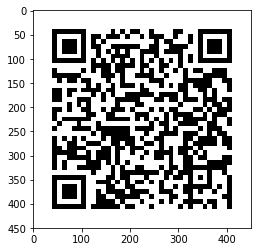

In [208]:
plt.imshow(img, cmap="gray")